# A Hands-On Introduction to CNNs with PyTorch

This notebook is to understand and build their first Convolutional Neural Network (CNN) using the PyTorch framework.


## 1: Why Do We Need CNNs?

Imagine you want to classify a simple 100x100 pixel color image using a standard Multi-Layer Perceptron (MLP).

*   **Input Size:** 100 (width) * 100 (height) * 3 (RGB channels) = **30,000 input features**.
*   You would first have to *flatten* this image into a single giant vector of 30,000 numbers.

This approach has two major problems:

1.  **Huge Number of Parameters:** If your first hidden layer has just 500 neurons, you would have 30,000 x 500 = **15 million** weights for just that one layer! This is computationally expensive, slow to train, and very prone to **overfitting**.

2.  **Loss of Spatial Information:** When you flatten the image, you lose all the spatial relationships between pixels. A pixel's relationship with its immediate neighbors is lost. This is not how images work! In an image, local groups of pixels form meaningful patterns like edges, corners, and textures.

### The CNN Solution

CNNs are designed to solve these problems by using two main ideas:

1.  **Convolution:** Uses learnable filters (kernels) that slide over the image to detect local patterns (like edges, corners, textures). This preserves spatial information and drastically reduces parameters through **parameter sharing** (using the same filter across the whole image).

2.  **Pooling:** Down-samples the feature maps created by the convolution layers. This makes the representation smaller and more manageable, and also makes the network more robust to small shifts in the position of features.

## 2: Setting Up Our PyTorch Environment

First, let's import the libraries we need. We will be using `torch` for the core framework and `torchvision` for datasets, model architectures, and image transformations.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3: Loading and Preparing the CIFAR-10 Dataset

PyTorch's `torchvision` makes it very easy to load standard datasets. We will also apply some transformations to our images.

1.  **`transforms.ToTensor()`**: This converts the images from PIL Image format (or NumPy array) into PyTorch Tensors.
2.  **`transforms.Normalize()`**: This normalizes the tensor image with a mean and standard deviation.

In [3]:
# Define a chain of transformations to apply to the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the batch size
batch_size = 4

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the class names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


### Let's Visualize Some Data

Let's check our data by plotting a few images from the training set.

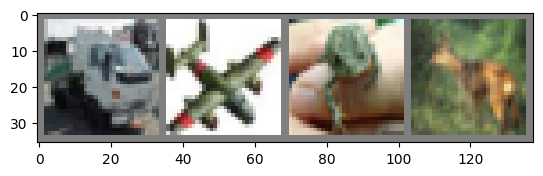

truck plane frog  deer 


In [4]:
def imshow(img):
    # Un-normalize the image to display it correctly
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 4: Building the CNN Model

In PyTorch, we define our neural network as a class that inherits from `nn.Module`.

- The layers of the network are defined in the `__init__` method.
- The forward pass (how data flows through the network) is defined in the `forward` method.

Our architecture will be:
`CONV1 -> RELU -> POOL1 -> CONV2 -> RELU -> POOL2 -> CONV3 -> RELU -> FC1 -> RELU -> FC2`

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        num_classes=10
        # 1. Convolutional Layers
        # nn.Conv2d(in_channels, out_channels, kernel_size)
        # Input image has 3 channels (RGB).
        # Choose the number of output channels to gradually increase feature maps (e.g., 32, 64...).
        # Kernel size is usually small (e.g., 3x3) with padding to keep the same spatial size.

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # 2. Pooling Layer
        # nn.MaxPool2d(kernel_size, stride)
        # Typically reduces spatial dimensions by half each time (common choice is 2x2).
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3. Fully Connected (Linear) Layers
        # After several pooling layers, the spatial dimension shrinks step by step.
        # Flatten the feature maps and connect them to fully connected layers.
        # The final layer should match the number of output classes (e.g., 10 for CIFAR-10).

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):
        # Convolutional Block 1
        # Input -> Conv -> Activation -> Pooling
        # Size reduces by half after pooling.

        x = self.pool(F.relu(self.conv1(x)))

        # Convolutional Block 2
        # Conv -> Activation -> Pooling

        x = self.pool(F.relu(self.conv2(x)))

        # Convolutional Block 3
        # Conv -> Activation -> Pooling

        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        # Number of input features = (channels * height * width).

        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        # Gradually reduce dimensions, last layer = number of classes.

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Output is raw logits, no activation here
        return x

# Create an instance of the network and move it to the correct device
net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 5: Defining a Loss Function and Optimizer

* **Loss Function**:  
  Which loss function should you use, and why?  
  For example, you can consider: `CrossEntropyLoss`, `BCELoss`, `MSELoss`, or `NLLLoss`.

* **Optimizer**:  
  Which optimizer would you choose to train the model, and why?  
  For example, you might use: `Adam`, `SGD with momentum`, or `RMSprop`.


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)

## 6: Training the Model

This is the core of the learning process. Unlike Keras's `.fit()` method, in PyTorch, we write the training loop ourselves. This gives us more control and is great for understanding what's happening under the hood.

The process for each batch is:
1.  Get a batch of `inputs` and `labels` from the `trainloader`.
2.  Move the data to the GPU .
3.  **Zero the gradients** This is critical!
4.  **Forward Pass**: Feed the inputs through the network.
5.  **Calculate Loss**: Compare the network's outputs with the true labels.
6.  **Backward Pass**: Calculate the gradients.
7.  **Update Weights**: The optimizer updates the network's weights based on the calculated gradients.

In [8]:
num_epochs = 5  # decide how many times to loop over the dataset

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # 1. Zero the parameter gradients
        optimizer.zero_grad()

        # Move data to device (GPU/CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2. Forward pass
        outputs = net(inputs)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Optimize
        optimizer.step()

        # Track statistics (hint: print every few batches, not every iteration)
        running_loss += loss.item()
        if (i + 1) % 500 == 0:
            avg_loss = running_loss / 500
            print(f"[Epoch {epoch+1}/{num_epochs}] Batch {i+1:5d}  Avg Loss: {avg_loss:.4f}")
            running_loss = 0.0

print('Finished Training')

[Epoch 1/5] Batch   500  Avg Loss: 2.1099
[Epoch 1/5] Batch  1000  Avg Loss: 1.8224
[Epoch 1/5] Batch  1500  Avg Loss: 1.6847
[Epoch 1/5] Batch  2000  Avg Loss: 1.5741
[Epoch 1/5] Batch  2500  Avg Loss: 1.4961
[Epoch 1/5] Batch  3000  Avg Loss: 1.4142
[Epoch 1/5] Batch  3500  Avg Loss: 1.4221
[Epoch 1/5] Batch  4000  Avg Loss: 1.4281
[Epoch 1/5] Batch  4500  Avg Loss: 1.3611
[Epoch 1/5] Batch  5000  Avg Loss: 1.3146
[Epoch 1/5] Batch  5500  Avg Loss: 1.3380
[Epoch 1/5] Batch  6000  Avg Loss: 1.2859
[Epoch 1/5] Batch  6500  Avg Loss: 1.2802
[Epoch 1/5] Batch  7000  Avg Loss: 1.2376
[Epoch 1/5] Batch  7500  Avg Loss: 1.2184
[Epoch 1/5] Batch  8000  Avg Loss: 1.2284
[Epoch 1/5] Batch  8500  Avg Loss: 1.2239
[Epoch 1/5] Batch  9000  Avg Loss: 1.1487
[Epoch 1/5] Batch  9500  Avg Loss: 1.1621
[Epoch 1/5] Batch 10000  Avg Loss: 1.1333
[Epoch 1/5] Batch 10500  Avg Loss: 1.1292
[Epoch 1/5] Batch 11000  Avg Loss: 1.1308
[Epoch 1/5] Batch 11500  Avg Loss: 1.0882
[Epoch 1/5] Batch 12000  Avg Loss:

## 7: Evaluating the Model

Now that the model is trained, let's see how it performs on the test dataset. We don't need to calculate gradients for evaluation, so we use `torch.no_grad()` to make the process faster and more memory-efficient.

We will also set our model to evaluation mode using `net.eval()`. This is important because some layers, like Dropout and BatchNorm, behave differently during training and evaluation.

In [9]:
correct = 0
total = 0

# Set model to evaluation mode
net.eval()

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Calculate outputs by running images through the network
        outputs = net(images)

        # The class with the highest probability is what we choose as prediction
        _, predicted = torch.max(outputs,1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')

Accuracy of the network on the 10000 test images: 70.69 %


## 8: Making Predictions on Individual Images

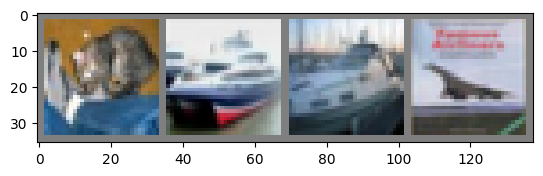

GroundTruth:  cat   ship  ship  plane
Predicted:    cat   ship  ship  ship 


In [10]:
# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print images and true labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Get predictions
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))


**Where to go from here?**
*   **Improve the model:** Try adding more layers, using different kernel sizes, or adding **Dropout** layers (`nn.Dropout`) to reduce overfitting.
*   **Data Augmentation:** Add more transformations (like random flips or rotations) to your `transform` pipeline to create a more robust model.